<a href="https://colab.research.google.com/github/danilsab24/Project-CV/blob/main/ASL_hand_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import of Librerie

In [12]:
import zipfile
import os

from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import shutil
import cv2

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import ToPILImage

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [3]:
# Define the path to your zip file
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/copia_dataset.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [ ]:
# Percorso della cartella di train
train_dir = "/content/sample_data/copia_dataset/asl_alphabet_validation"

# Controlla quante cartelle ci sono e per ogni cartella il numero di immagini presenti
def count_images_in_folders(directory):
    folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    folder_image_counts = {}

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        folder_image_counts[folder] = len(images)

    return folder_image_counts

# Esegui la funzione e stampa i risultati
folder_image_counts = count_images_in_folders(train_dir)

print(f"Numero totale di cartelle: {len(folder_image_counts)}\n")
for folder, count in folder_image_counts.items():
    print(f"Cartella '{folder}' contiene {count} immagini.")


Numero totale di cartelle: 29

Cartella 'M' contiene 0 immagini.
Cartella 'A' contiene 0 immagini.
Cartella 'H' contiene 0 immagini.
Cartella 'nothing' contiene 0 immagini.
Cartella 'I' contiene 0 immagini.
Cartella 'Y' contiene 0 immagini.
Cartella 'D' contiene 0 immagini.
Cartella 'O' contiene 0 immagini.
Cartella 'space' contiene 0 immagini.
Cartella 'W' contiene 0 immagini.
Cartella 'P' contiene 0 immagini.
Cartella 'B' contiene 0 immagini.
Cartella 'Z' contiene 0 immagini.
Cartella 'G' contiene 0 immagini.
Cartella 'C' contiene 0 immagini.
Cartella 'E' contiene 0 immagini.
Cartella 'N' contiene 0 immagini.
Cartella 'F' contiene 0 immagini.
Cartella 'S' contiene 0 immagini.
Cartella 'T' contiene 0 immagini.
Cartella 'X' contiene 0 immagini.
Cartella 'K' contiene 0 immagini.
Cartella 'L' contiene 0 immagini.
Cartella 'R' contiene 0 immagini.
Cartella 'del' contiene 0 immagini.
Cartella 'U' contiene 0 immagini.
Cartella 'Q' contiene 0 immagini.
Cartella 'J' contiene 0 immagini.
Carte

# Data Mangement

# Removing image without bounding box

In [ ]:
def has_bounding_box(image_path, bbox_color=(23, 245, 21)):
    # Legge l'immagine
    image = cv2.imread(image_path)
    if image is None:
        return False

    # Converti l'immagine in formato RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crea una maschera per il colore specifico della bounding box
    lower_bound = np.array(bbox_color) - 10
    upper_bound = np.array(bbox_color) + 10
    mask = cv2.inRange(image_rgb, lower_bound, upper_bound)

    # Trova i contorni della maschera
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:  # Verifica se il contorno è rettangolare
            return True
    return False

def count_images_without_bbox(root_path, bbox_color=(23, 245, 21)):

    count_without_bbox = 0

    # Cartelle di output da controllare
    output_dirs = [
        'asl_alphabet_test',
        'asl_alphabet_train',
        'asl_alphabet_validation'
    ]

    # Sotto-cartelle delle lettere
    sub_dirs = [
        'A_label', 'B_label', 'C_label', 'D_label', 'E_label', 'F_label', 'G_label', 'H_label', 'I_label', 'J_label', 'K_label', 'L_label', 'M_label',
        'N_label', 'O_label', 'P_label', 'Q_label', 'R_label', 'S_label', 'T_label', 'U_label', 'V_label', 'W_label', 'X_label', 'Y_label', 'Z_label',
        'del_label', 'nothing_label', 'space_label'
    ]

    for output_dir in output_dirs:
        for sub_dir in sub_dirs:
            dir_path = os.path.join(root_path, 'output', output_dir, sub_dir)
            if not os.path.exists(dir_path):
                continue
            for image_name in os.listdir(dir_path):
                image_path = os.path.join(dir_path, image_name)
                if not has_bounding_box(image_path, bbox_color):
                    count_without_bbox += 1

    return count_without_bbox

# Percorso della cartella radice
root_path = '/content/sample_data/copia_dataset'

# Conta delle immagini senza bounding box
count = count_images_without_bbox(root_path)

# Stampa del risultato
print(f"Numero di immagini senza bounding box: {count}")


Numero di immagini senza bounding box: 48922


In [4]:
def has_bounding_box(image_path, bbox_color=(23, 245, 21)):

    # Legge l'immagine
    image = cv2.imread(image_path)
    if image is None:
        return False

    # Converti l'immagine in formato RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crea una maschera per il colore specifico della bounding box
    lower_bound = np.array(bbox_color) - 10
    upper_bound = np.array(bbox_color) + 10
    mask = cv2.inRange(image_rgb, lower_bound, upper_bound)

    # Trova i contorni della maschera
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:  # Verifica se il contorno è rettangolare
            return True
    return False

def delete_images_without_bbox(root_path, bbox_color=(23, 245, 21)):

    count_deleted = 0

    # Cartelle di output da controllare
    output_dirs = [
        'asl_alphabet_test',
        'asl_alphabet_train',
        'asl_alphabet_validation'
    ]

    # Sotto-cartelle delle lettere
    sub_dirs = [
        'A_label', 'B_label', 'C_label', 'D_label', 'E_label', 'F_label', 'G_label', 'H_label', 'I_label', 'J_label', 'K_label', 'L_label', 'M_label',
        'N_label', 'O_label', 'P_label', 'Q_label', 'R_label', 'S_label', 'T_label', 'U_label', 'V_label', 'W_label', 'X_label', 'Y_label', 'Z_label',
        'del_label', 'nothing_label', 'space_label'
    ]

    for output_dir in output_dirs:
        for sub_dir in sub_dirs:
            dir_path = os.path.join(root_path, 'output', output_dir, sub_dir)
            if not os.path.exists(dir_path):
                continue
            for image_name in os.listdir(dir_path):
                image_path = os.path.join(dir_path, image_name)
                if not has_bounding_box(image_path, bbox_color):
                    os.remove(image_path)
                    count_deleted += 1

    return count_deleted

# Percorso della cartella radice
root_path = '/content/sample_data/copia_dataset'

# Elimina le immagini senza bounding box
count_deleted = delete_images_without_bbox(root_path)

# Stampa del risultato
print(f"Numero di immagini eliminate: {count_deleted}")


Numero di immagini eliminate: 48922


In [ ]:
# Percorso della cartella radice
root_path = '/content/sample_data/copia_dataset'

# Conta delle immagini senza bounding box
count = count_images_without_bbox(root_path)

# Stampa del risultato
print(f"Numero di immagini senza bounding box: {count}")

Numero di immagini senza bounding box: 0


# Remove image without that do not have a one-to-one correspondence

In [5]:
import os
from collections import Counter

# Definizione dei percorsi principali
base_path = "/content/sample_data/copia_dataset"
train_path = os.path.join(base_path, "asl_alphabet_train")
validation_path = os.path.join(base_path, "asl_alphabet_validation")
test_path = os.path.join(base_path, "asl_alphabet_test")

output_train_path = os.path.join(base_path, "output", "asl_alphabet_train")
output_validation_path = os.path.join(base_path, "output", "asl_alphabet_validation")
output_test_path = os.path.join(base_path, "output", "asl_alphabet_test")

# Definizione delle categorie
categories = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'del', 'nothing', 'space'
]

# Funzione per contare e rimuovere le immagini senza corrispondenza
def count_and_remove_non_matches(base_path, output_path, categories):
    matches_counter = Counter()
    non_matches_counter = Counter()

    for category in categories:
        input_category_path = os.path.join(base_path, category)
        output_category_path = os.path.join(output_path, f"{category}_label")

        input_images = set(os.listdir(input_category_path))
        output_images = set(os.listdir(output_category_path))

        # Rimuovere il suffisso _label dai nomi delle immagini in output
        output_images = {img.replace('_label', '') for img in output_images}

        # Contare le corrispondenze e le non corrispondenze
        matches = input_images.intersection(output_images)
        non_matches = input_images.difference(output_images)

        matches_counter[category] = len(matches)
        non_matches_counter[category] = len(non_matches)

        # Rimuovere le immagini senza corrispondenza
        for non_match in non_matches:
            os.remove(os.path.join(input_category_path, non_match))

    return matches_counter, non_matches_counter

# Funzione per contare il numero di immagini in una cartella
def count_images_in_category(base_path, categories):
    count = Counter()
    for category in categories:
        category_path = os.path.join(base_path, category)
        count[category] = len(os.listdir(category_path))
    return count

# Stampare le dimensioni delle cartelle prima della rimozione
print("Dimensioni delle cartelle prima della rimozione:")
print("Train:", count_images_in_category(train_path, categories))
print("Validation:", count_images_in_category(validation_path, categories))
print("Test:", count_images_in_category(test_path, categories))

# Calcolare e rimuovere le immagini senza corrispondenza
train_matches, train_non_matches = count_and_remove_non_matches(train_path, output_train_path, categories)
validation_matches, validation_non_matches = count_and_remove_non_matches(validation_path, output_validation_path, categories)
test_matches, test_non_matches = count_and_remove_non_matches(test_path, output_test_path, categories)

# Stampare i risultati della rimozione
print("\nCorrispondenze nel set di allenamento:")
print(train_matches)
print("Immagini senza corrispondenza nel set di allenamento:")
print(train_non_matches)

print("\nCorrispondenze nel set di validazione:")
print(validation_matches)
print("Immagini senza corrispondenza nel set di validazione:")
print(validation_non_matches)

print("\nCorrispondenze nel set di test:")
print(test_matches)
print("Immagini senza corrispondenza nel set di test:")
print(test_non_matches)

# Stampare le dimensioni delle cartelle dopo la rimozione
print("\nDimensioni delle cartelle dopo la rimozione:")
print("Train:", count_images_in_category(train_path, categories))
print("Validation:", count_images_in_category(validation_path, categories))
print("Test:", count_images_in_category(test_path, categories))


Dimensioni delle cartelle prima della rimozione:
Train: Counter({'A': 3633, 'B': 3323, 'Y': 3271, 'C': 3258, 'O': 3256, 'S': 3243, 'X': 3237, 'T': 3221, 'F': 3212, 'U': 3209, 'R': 3208, 'I': 3181, 'Q': 3181, 'L': 3175, 'N': 3172, 'H': 3162, 'M': 3160, 'K': 3150, 'G': 3137, 'W': 3114, 'E': 3097, 'D': 3051, 'P': 3040, 'V': 3038, 'J': 3001, 'Z': 2964, 'space': 2828, 'del': 2734, 'nothing': 1212})
Validation: Counter({'A': 761, 'B': 747, 'Y': 736, 'C': 733, 'O': 732, 'S': 729, 'X': 728, 'T': 724, 'F': 722, 'U': 722, 'R': 721, 'I': 715, 'Q': 715, 'L': 714, 'N': 713, 'H': 711, 'M': 711, 'K': 708, 'G': 706, 'W': 700, 'E': 697, 'D': 686, 'P': 684, 'V': 683, 'J': 675, 'Z': 666, 'space': 636, 'del': 615, 'nothing': 272})
Test: Counter({'A': 846, 'B': 832, 'Y': 817, 'C': 814, 'O': 814, 'S': 810, 'X': 809, 'T': 805, 'F': 803, 'R': 802, 'U': 802, 'I': 795, 'Q': 795, 'L': 793, 'N': 793, 'H': 790, 'M': 790, 'K': 787, 'G': 784, 'W': 778, 'E': 774, 'D': 763, 'P': 760, 'V': 759, 'J': 750, 'Z': 741, 'spa

In [ ]:
def find_unmatched_images(input_dir, output_dir, labels):
    unmatched_count = 0
    unmatched_images = []

    for label in labels:
        input_path = os.path.join(input_dir, label)
        output_path = os.path.join(output_dir, f"{label}_label")

        input_images = sorted(os.listdir(input_path))

        for input_image in input_images:
            input_image_path = os.path.join(input_path, input_image)
            output_image_name = input_image.rsplit('.', 1)[0] + '_label.' + input_image.rsplit('.', 1)[1]
            output_image_path = os.path.join(output_path, output_image_name)

            if not os.path.exists(output_image_path):
                unmatched_count += 1
                unmatched_images.append(input_image_path)

    return unmatched_count, unmatched_images

# Directory paths
base_dir = '/content/sample_data/copia_dataset'
train_input_dir = os.path.join(base_dir, 'asl_alphabet_train')
validation_input_dir = os.path.join(base_dir, 'asl_alphabet_validation')
test_input_dir = os.path.join(base_dir, 'asl_alphabet_test')

train_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_train')
validation_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_validation')
test_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_test')

# Labels to consider
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'del', 'nothing', 'space']

# Find unmatched images in train, validation and test sets
train_unmatched_count, train_unmatched_images = find_unmatched_images(train_input_dir, train_output_dir, labels)
validation_unmatched_count, validation_unmatched_images = find_unmatched_images(validation_input_dir, validation_output_dir, labels)
test_unmatched_count, test_unmatched_images = find_unmatched_images(test_input_dir, test_output_dir, labels)

total_unmatched_count = train_unmatched_count + validation_unmatched_count + test_unmatched_count

print(f"Total unmatched images: {total_unmatched_count}")
print(f"Train unmatched images: {train_unmatched_count}")
print(f"Validation unmatched images: {validation_unmatched_count}")
print(f"Test unmatched images: {test_unmatched_count}")


Total unmatched images: 0
Train unmatched images: 0
Validation unmatched images: 0
Test unmatched images: 0


# Plot of some images

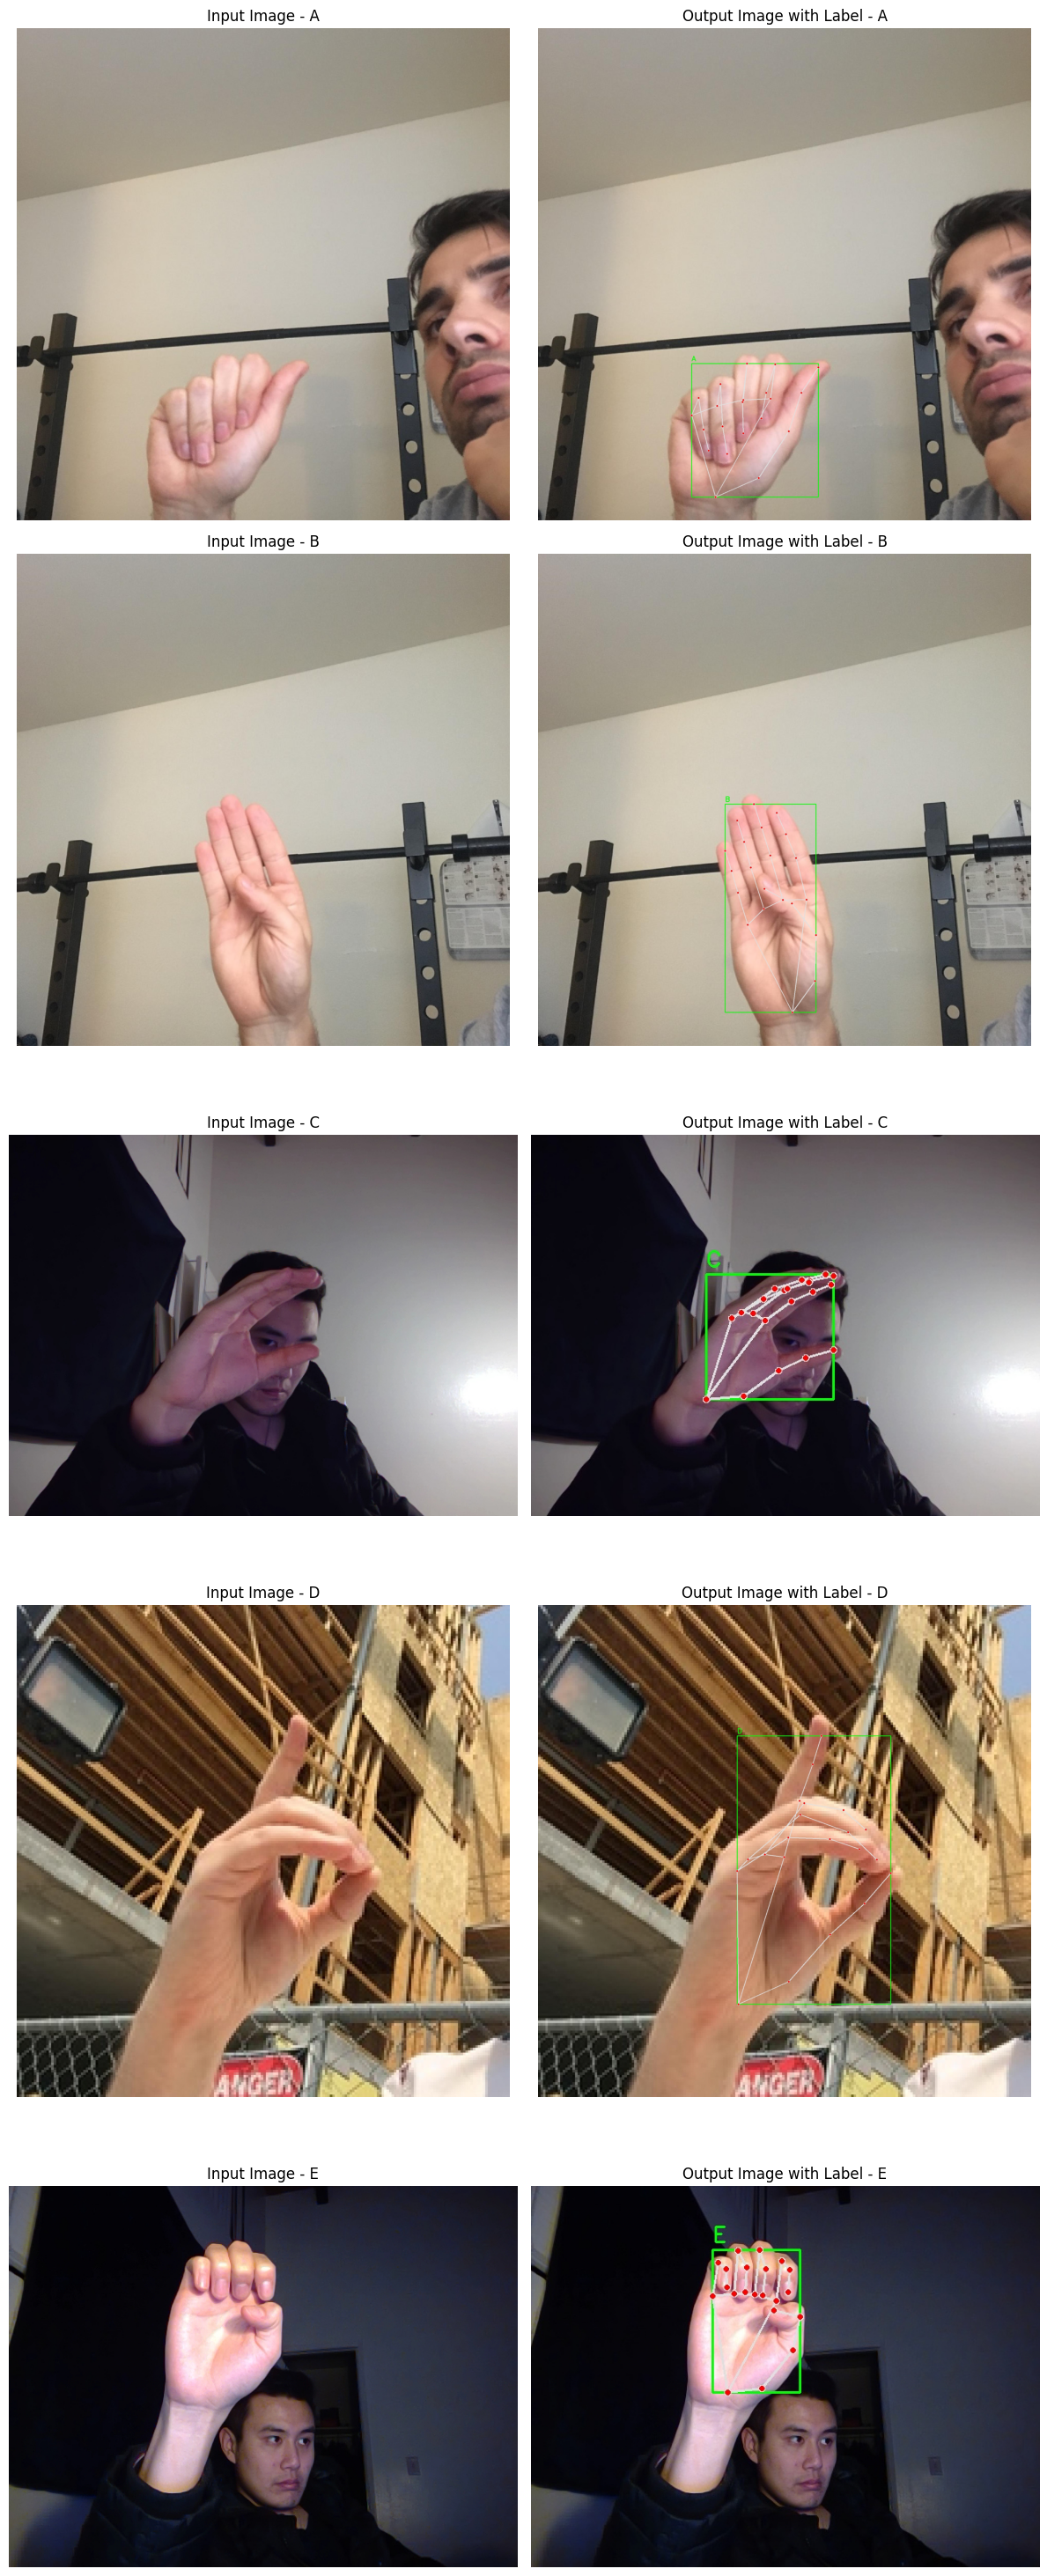

In [ ]:
def plot_images_from_multiple_labels(input_dir, output_dir, labels, images_per_label=1):
    fig, axes = plt.subplots(images_per_label * len(labels), 2, figsize=(12, 6*images_per_label*len(labels)))

    count = 0
    for label in labels:
        input_path = os.path.join(input_dir, label)
        output_path = os.path.join(output_dir, f"{label}_label")

        input_images = sorted(os.listdir(input_path))[:images_per_label]

        for input_image in input_images:
            input_image_path = os.path.join(input_path, input_image)
            output_image_name = input_image.split('.')[0] + '_label.' + input_image.split('.')[1]  # assuming the images have extensions like .jpg or .png
            output_image_path = os.path.join(output_path, output_image_name)

            if not os.path.exists(output_image_path):
                print(f"Warning: Corresponding output image not found for {input_image_path}")
                continue

            input_img = Image.open(input_image_path)
            output_img = Image.open(output_image_path)

            axes[count, 0].imshow(input_img)
            axes[count, 0].set_title(f'Input Image - {label}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(output_img)
            axes[count, 1].set_title(f'Output Image with Label - {label}')
            axes[count, 1].axis('off')

            count += 1

    plt.tight_layout()
    plt.show()

# Directory paths
base_dir = '/content/sample_data/copia_dataset'
input_dir = os.path.join(base_dir, 'asl_alphabet_train')
output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_train')

# Labels to consider
labels = ['A', 'B', 'C', 'D', 'E']  # Change these to the labels you want to plot

# Plot images from multiple labels
plot_images_from_multiple_labels(input_dir, output_dir, labels, images_per_label=1)


In [ ]:
import shutil
from pathlib import Path

# Percorso della directory da svuotare
directory_to_clear = Path('/content/sample_data/copia_dataset')

# Funzione per eliminare tutto il contenuto della directory
def clear_directory(directory_path):
    if directory_path.exists() and directory_path.is_dir():
        shutil.rmtree(directory_path)
        print(f"Tutto il contenuto di {directory_path} è stato eliminato.")
        # Ricrea la directory dopo averla eliminata
        directory_path.mkdir(parents=True, exist_ok=True)
    else:
        print(f"La directory {directory_path} non esiste o non è una directory valida.")

# Esegui la funzione per svuotare la directory
#clear_directory(directory_to_clear)


Tutto il contenuto di /content/sample_data/copia_dataset è stato eliminato.


# Check dimension

In [ ]:
def check_image_dimensions(directory):
    dimensions = None
    all_same = True

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg')):
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    current_dimensions = img.size

                    if dimensions is None:
                        dimensions = current_dimensions
                    elif current_dimensions != dimensions:
                        print(f"Dimension mismatch found in file: {image_path} (Dimensions: {current_dimensions})")
                        all_same = False

    if all_same:
        print("All images have the same dimensions:", dimensions)
    else:
        print("Not all images have the same dimensions.")

# Path to the directory containing the images
directory_path = "/content/sample_data/copia_dataset"

# Check if all images have the same dimensions
check_image_dimensions(directory_path)

# Code for trainloader validation loader e trainloader



In [6]:
class ASLAlphabetDataset(Dataset):
    def __init__(self, input_dir, output_dir, labels, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.labels = labels
        self.transform = transform
        self.image_pairs = self._create_image_pairs()

    def _create_image_pairs(self):
        image_pairs = []
        for label in self.labels:
            input_path = os.path.join(self.input_dir, label)
            output_path = os.path.join(self.output_dir, f"{label}_label")

            input_images = sorted(os.listdir(input_path))

            for input_image in input_images:
                input_image_path = os.path.join(input_path, input_image)
                # Assuming output image has the same name as input image with '_label' suffix
                output_image_name = input_image.split('.')[0] + '_label.' + input_image.split('.')[1]
                output_image_path = os.path.join(output_path, output_image_name)

                if os.path.exists(output_image_path):
                    image_pairs.append((input_image_path, output_image_path, label))

        return image_pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_image_path, output_image_path, label = self.image_pairs[idx]
        input_image = Image.open(input_image_path).convert("RGB")
        output_image = Image.open(output_image_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        label_index = self.labels.index(label)

        return input_image, output_image, label_index

In [7]:
# Directory paths
base_dir = '/content/sample_data/copia_dataset'
train_input_dir = os.path.join(base_dir, 'asl_alphabet_train')
validation_input_dir = os.path.join(base_dir, 'asl_alphabet_validation')
test_input_dir = os.path.join(base_dir, 'asl_alphabet_test')

# Output directories
train_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_train')
validation_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_validation')
test_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_test')

# Labels to consider
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'del', 'nothing', 'space']

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = ASLAlphabetDataset(train_input_dir, train_output_dir, labels, transform=transform)
validation_dataset = ASLAlphabetDataset(validation_input_dir, validation_output_dir, labels, transform=transform)
test_dataset = ASLAlphabetDataset(test_input_dir, test_output_dir, labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
def count_classes(data_loader):
    all_labels = []
    for _, _, labels in data_loader:
        all_labels.extend(labels.numpy())
    unique_labels = np.unique(all_labels)
    return len(unique_labels), unique_labels

# Count classes in each loader
train_classes_count, train_unique_labels = count_classes(train_loader)
validation_classes_count, validation_unique_labels = count_classes(validation_loader)
test_classes_count, test_unique_labels = count_classes(test_loader)

print(f'Number of classes in train_loader: {train_classes_count}')
print(f'Unique labels in train_loader: {train_unique_labels}')
print(f'Number of classes in validation_loader: {validation_classes_count}')
print(f'Unique labels in validation_loader: {validation_unique_labels}')
print(f'Number of classes in test_loader: {test_classes_count}')
print(f'Unique labels in test_loader: {test_unique_labels}')

Number of classes in train_loader: 29
Unique labels in train_loader: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Number of classes in validation_loader: 29
Unique labels in validation_loader: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Number of classes in test_loader: 28
Unique labels in test_loader: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28]


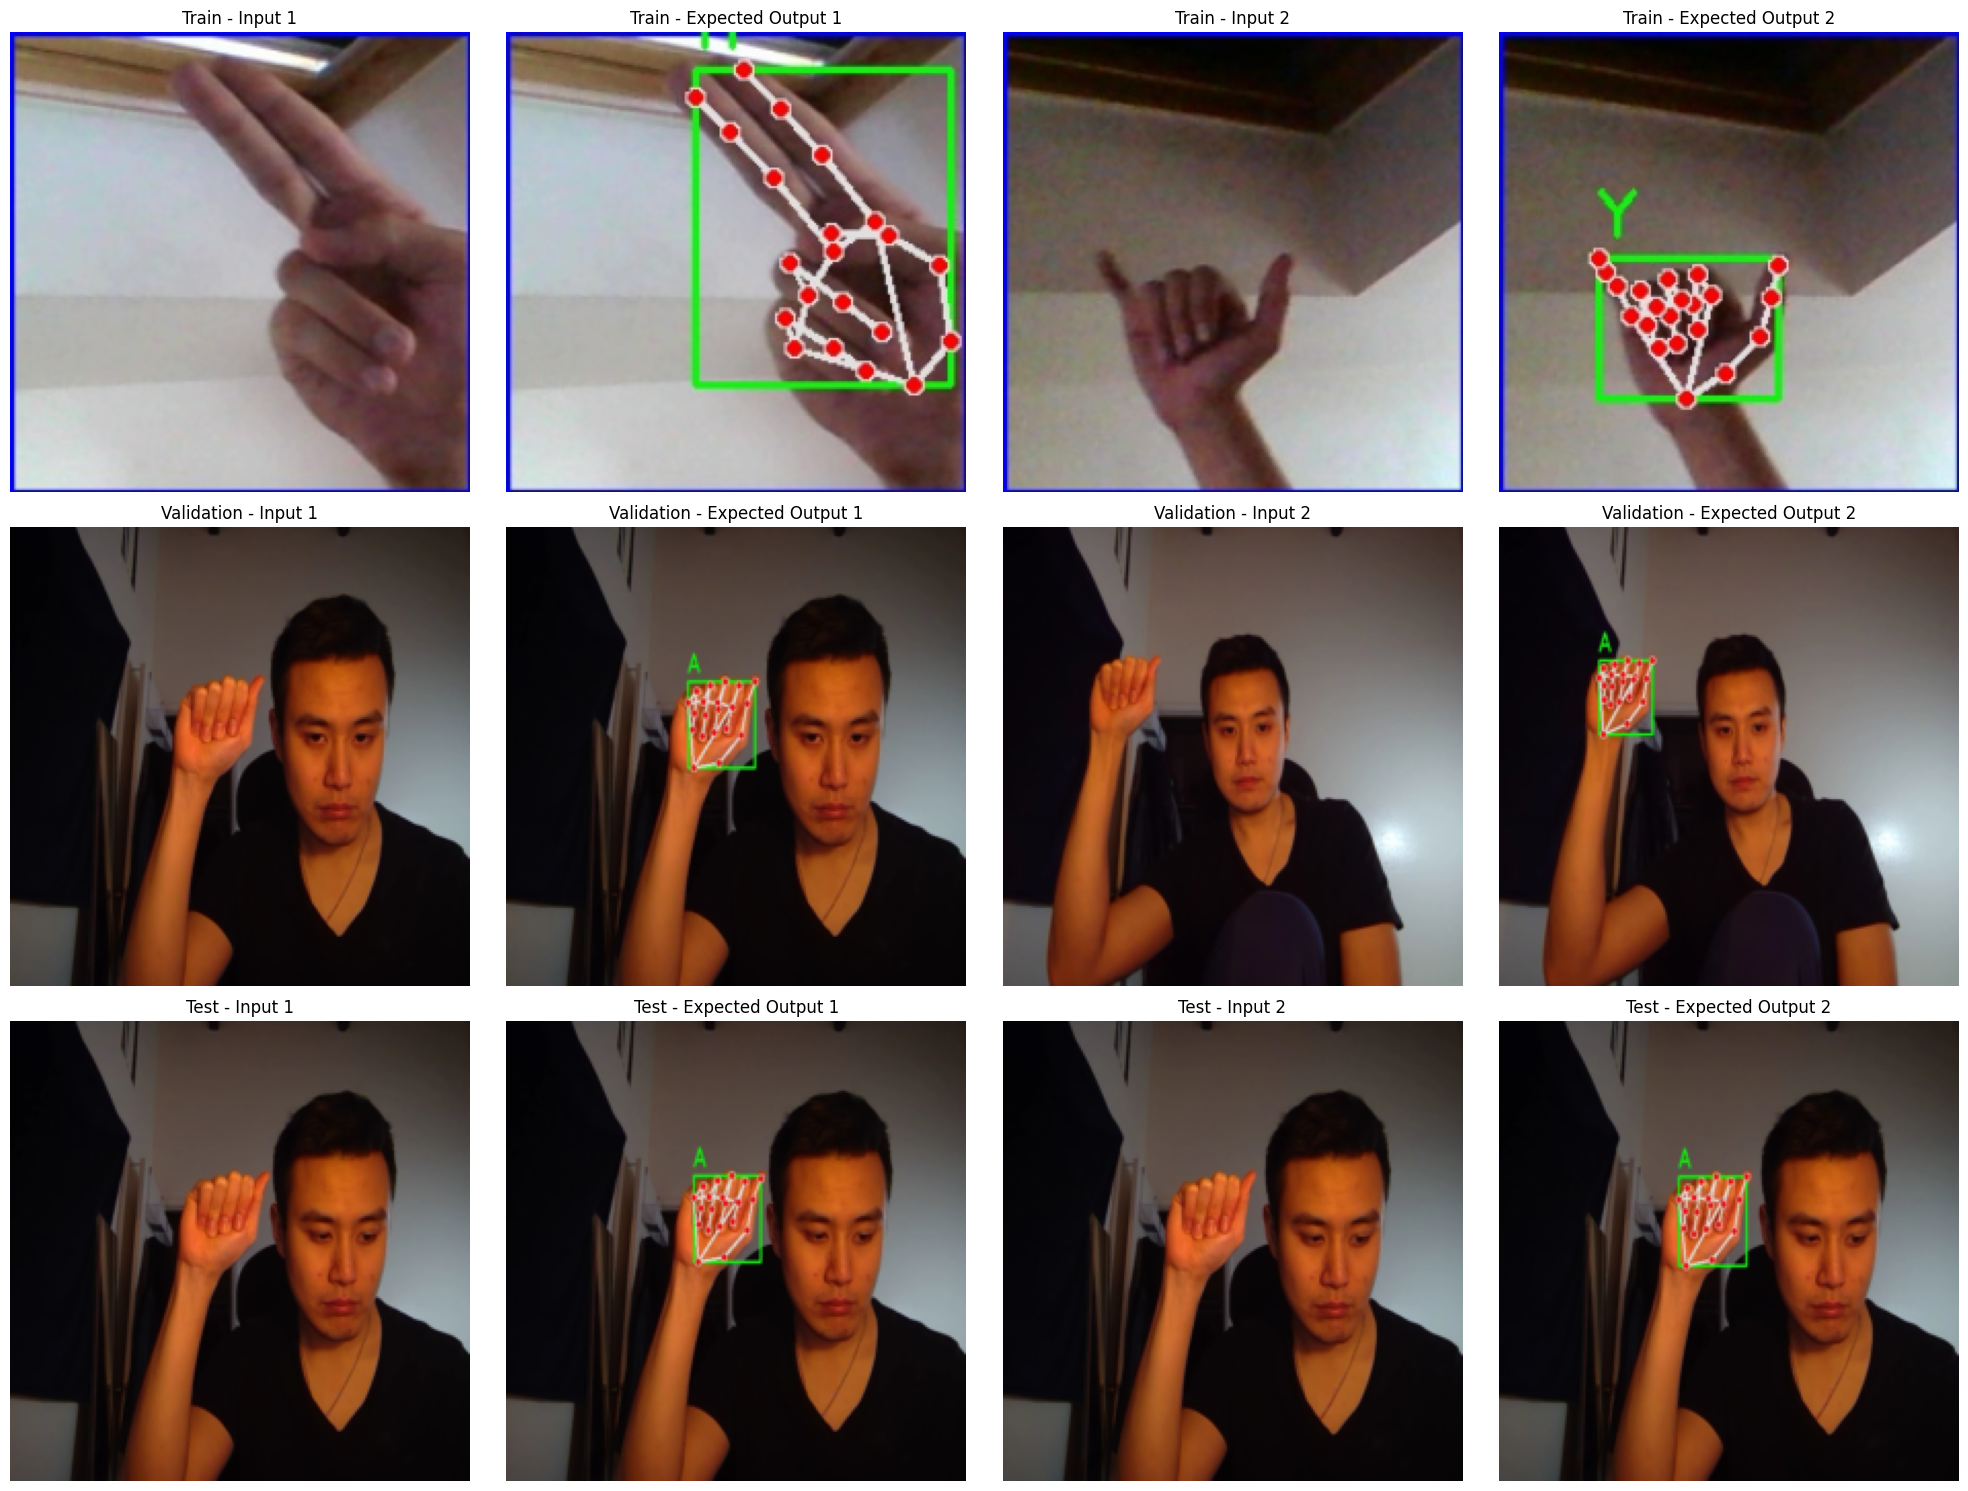

In [ ]:
# Function to display images
def imshow(image, ax, title):
    image = image.permute(1, 2, 0)  # Change to HWC
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
    image = torch.clamp(image, 0, 1)  # Clamp values to be between 0 and 1
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

# Plotting images from train, validation, and test datasets
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, (loader, dataset_type) in enumerate(zip([train_loader, validation_loader, test_loader], ['Train', 'Validation', 'Test'])):
    inputs, outputs, labels = next(iter(loader))
    for j in range(2):
        ax_input = axes[i, 2*j]
        imshow(inputs[j], ax_input, title=f'{dataset_type} - Input {j+1}')
        ax_output = axes[i, 2*j+1]
        imshow(outputs[j], ax_output, title=f'{dataset_type} - Expected Output {j+1}')

plt.tight_layout()
plt.show()


# CNN

In [8]:
class HandGestureCNN(nn.Module):
    def __init__(self, num_classes):
        super(HandGestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
num_classes = 29
model = HandGestureCNN(num_classes=num_classes)

In [10]:
# Liste per tracciare le metriche
train_losses = []
val_losses = []
val_accuracies = []

# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

HandGestureCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=29, bias=True)
)

# Train

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Ogni epoca ha una fase di addestramento e una di validazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Impostare il modello in modalità training
                dataloader = train_loader
            else:
                model.eval()  # Impostare il modello in modalità evaluation
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterare sui dati con tqdm per visualizzare la barra di progresso
            for batch in tqdm(dataloader, desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = batch[0].to(device)
                labels = batch[2].to(device)  # labels is now the third element in the batch

                # Debugging delle dimensioni degli input e delle etichette
                #print(f"Inputs size: {inputs.size()}, Labels size: {labels.size()}")

                # Resettare i gradienti dell'ottimizzatore
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # Backward + ottimizzazione solo nella fase di addestramento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Salvare le metriche
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # Copiare il modello se ha migliorato la accuratezza su validation
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')

    # Caricare i pesi migliori del modello
    model.load_state_dict(best_model_wts)
    return model

# Supponiamo che il modello, il criterion e l'optimizer siano già definiti
model = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=15)

# Percorso di salvataggio
save_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth'

# Salvare il modello e le metriche
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
}, save_path)

print(f"Modello e metriche salvate con successo in {save_path}.")

Epoch 0/14
----------


train Loss: 0.8320 Acc: 0.7395


val Loss: 0.2208 Acc: 0.9380
Epoch 1/14
----------


train Loss: 0.2527 Acc: 0.9216


val Loss: 0.1154 Acc: 0.9696
Epoch 2/14
----------


train Loss: 0.1533 Acc: 0.9529


val Loss: 0.1014 Acc: 0.9752
Epoch 3/14
----------


train Loss: 0.1141 Acc: 0.9652


val Loss: 0.0866 Acc: 0.9813
Epoch 4/14
----------


train Loss: 0.0938 Acc: 0.9728


val Loss: 0.0926 Acc: 0.9800
Epoch 5/14
----------


train Loss: 0.0713 Acc: 0.9796


val Loss: 0.0871 Acc: 0.9825
Epoch 6/14
----------


train Loss: 0.0680 Acc: 0.9814


val Loss: 0.0858 Acc: 0.9849
Epoch 7/14
----------


train Loss: 0.0600 Acc: 0.9829


val Loss: 0.1076 Acc: 0.9816
Epoch 8/14
----------


train Loss: 0.0612 Acc: 0.9835


val Loss: 0.1132 Acc: 0.9856
Epoch 9/14
----------


train Loss: 0.0496 Acc: 0.9870


val Loss: 0.1105 Acc: 0.9848
Epoch 10/14
----------


train Loss: 0.0573 Acc: 0.9858


val Loss: 0.1089 Acc: 0.9838
Epoch 11/14
----------


train Loss: 0.0471 Acc: 0.9876


val Loss: 0.1339 Acc: 0.9851
Epoch 12/14
----------


train Loss: 0.0483 Acc: 0.9887


val Loss: 0.1596 Acc: 0.9858
Epoch 13/14
----------


train Loss: 0.0486 Acc: 0.9883


val Loss: 0.1520 Acc: 0.9818
Epoch 14/14
----------


train Loss: 0.0461 Acc: 0.9896


val Loss: 0.1941 Acc: 0.9809
Best val Acc: 0.9858
Modello e metriche salvate con successo in /content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth.


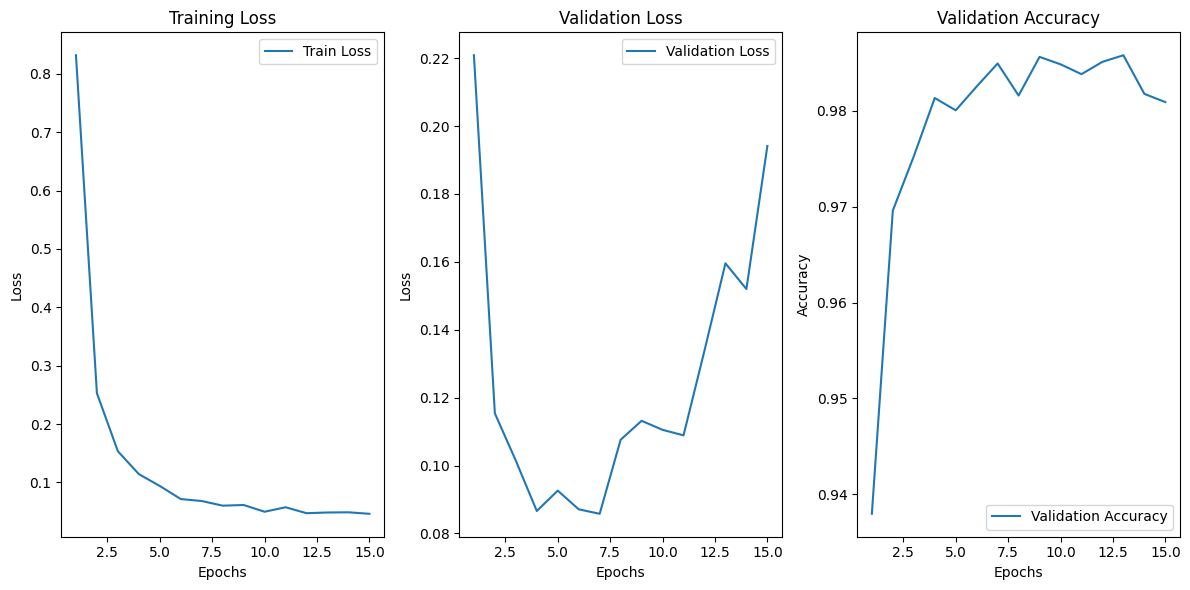

In [ ]:
# Percorso del file salvato
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth'

# Caricamento del file con mappatura su CPU
checkpoint = torch.load(file_path, map_location=torch.device('cpu'))

# Recupero delle metriche
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

# Conversione dei tensori in numpy arrays se necessario
if isinstance(val_accuracies[0], torch.Tensor):
    val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

# Plot delle metriche
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Plot del training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot del validation loss
plt.subplot(1, 3, 2)
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

# Plot della validation accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Test of CNN

Accuracy: 0.9995
Precision: 0.9994
Recall: 0.9995
F1 Score: 0.9994
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       508
           B       1.00      1.00      1.00       489
           C       1.00      1.00      1.00       412
           D       1.00      1.00      1.00       481
           E       1.00      1.00      1.00       474
           F       1.00      1.00      1.00       634
           G       1.00      1.00      1.00       536
           H       1.00      1.00      1.00       480
           I       1.00      1.00      1.00       456
           J       1.00      1.00      1.00       500
           K       1.00      1.00      1.00       522
           L       1.00      1.00      1.00       574
           M       1.00      1.00      1.00       341
           N       1.00      1.00      1.00       261
           O       1.00      1.00      1.00       462
           P       1.00      1.00      1.00  

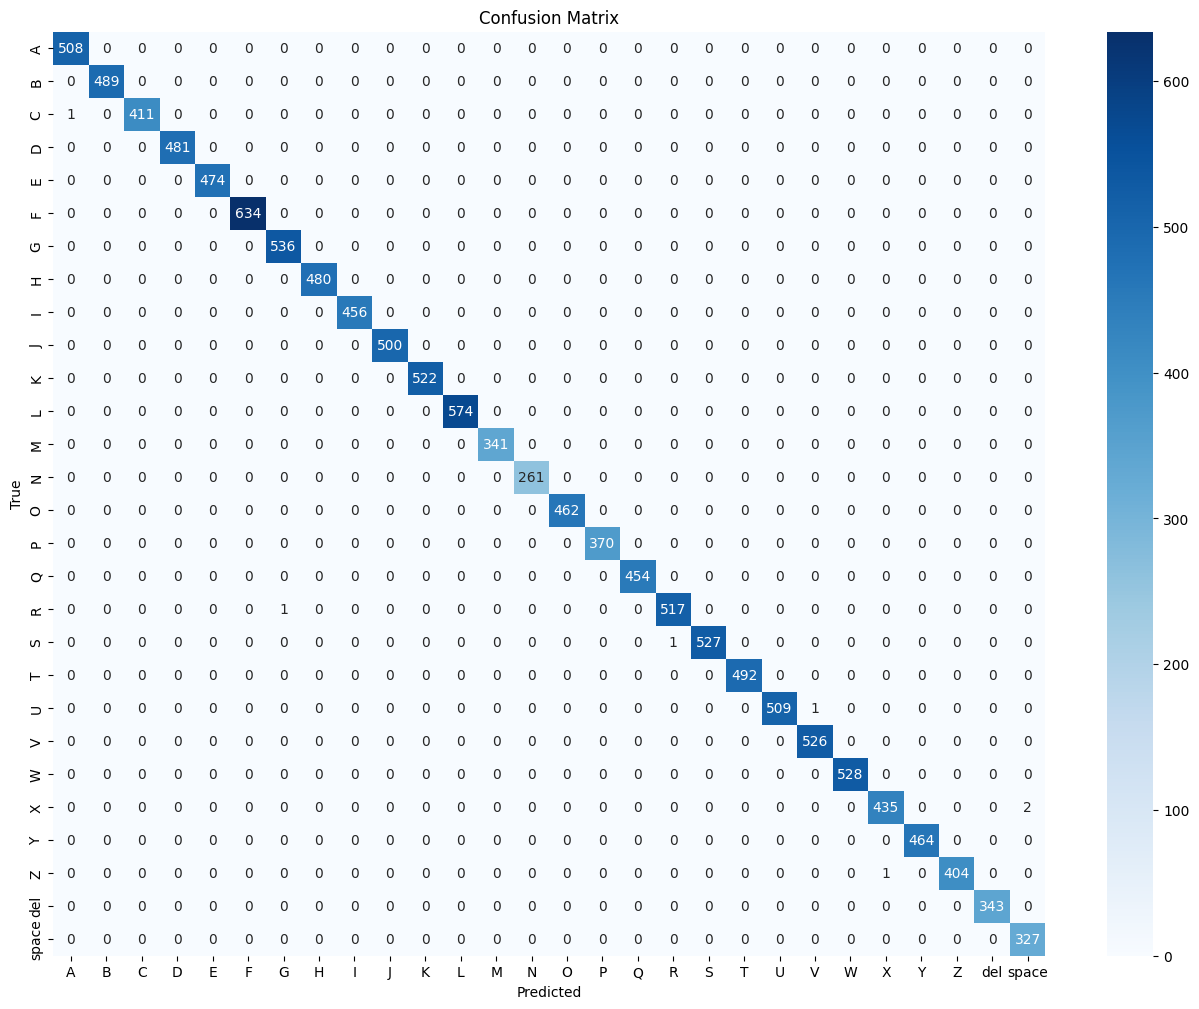

In [15]:
# Carica il modello
model_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(model_path, map_location=device)

num_classes = 29
model = HandGestureCNN(num_classes=num_classes)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

# Esecuzione del test
all_preds = []
all_labels = []

# Labels to consider
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'del', 'nothing', 'space']

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing', leave=False):
        inputs = batch[0].to(device)
        batch_labels = batch[2].to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Calcolo delle etichette uniche presenti nei dati di test
unique_labels = sorted(list(set(all_labels)))
unique_label_names = [labels[i] for i in unique_labels]

# Calcolo delle metriche
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
class_report = classification_report(all_labels, all_preds, target_names=unique_label_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Classification Report:')
print(class_report)

# Plot della confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_label_names, yticklabels=unique_label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


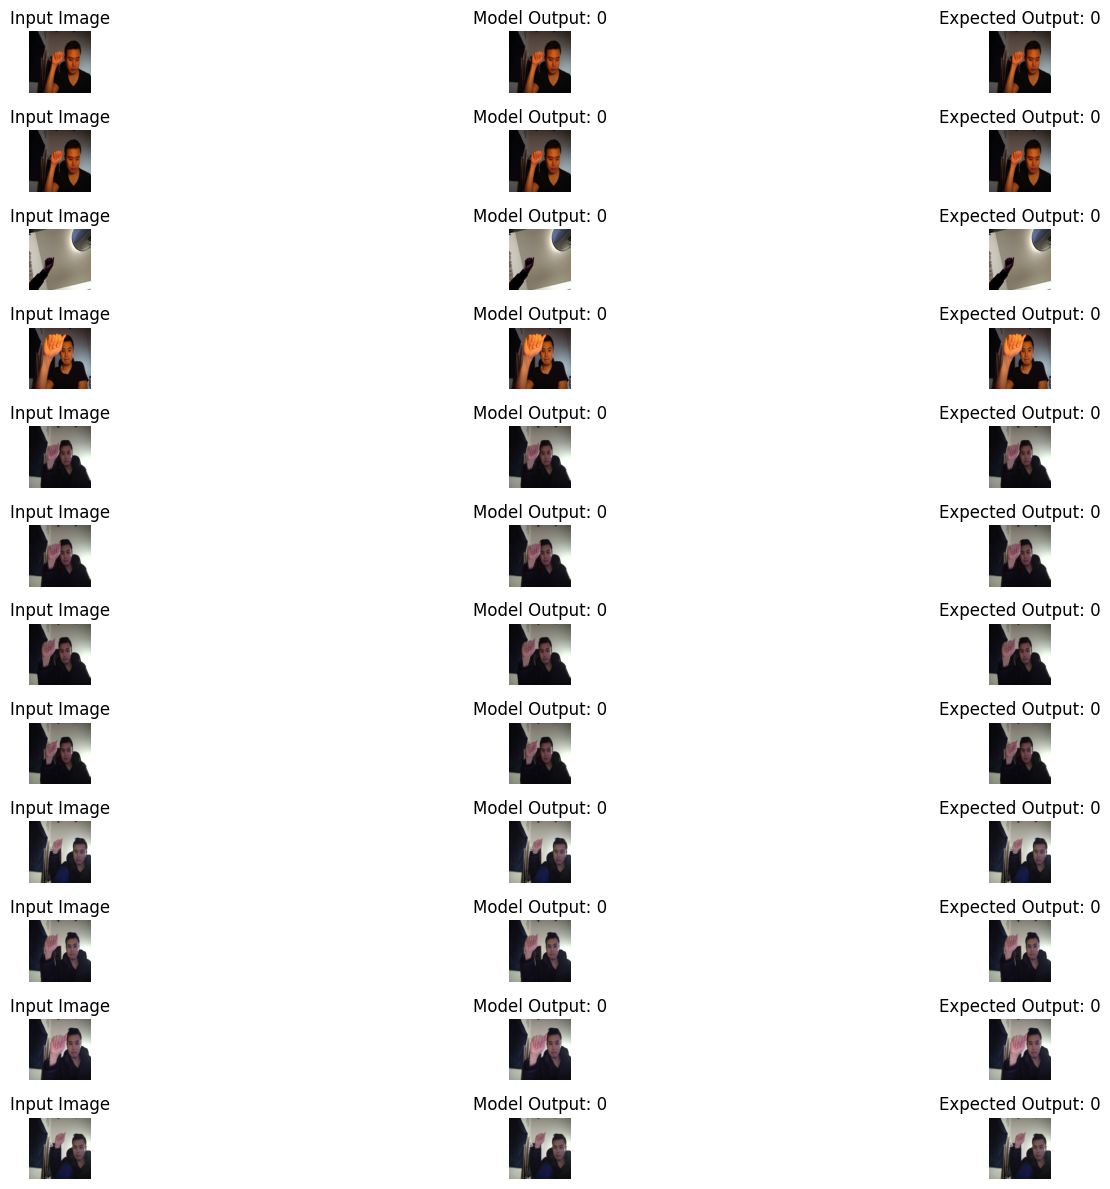

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Percorso del modello salvato
model_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth'

# Imposta il dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caricare il modello e i pesi
num_classes = 29
model = HandGestureCNN(num_classes=num_classes)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # Sposta il modello sul dispositivo corretto
model.eval()

# Definizione delle trasformazioni inverse per convertire i tensori in immagini
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                         std=[1/0.229, 1/0.224, 1/0.225]),
    ToPILImage()
])

# Funzione per ottenere predizioni e immagini attese
def get_predictions_and_labels(dataset, model, num_images=12):
    images, preds, labels = [], [], []
    for i in range(num_images):
        input_image, label_index = dataset[i]
        with torch.no_grad():
            input_image = input_image.unsqueeze(0).to(device)  # Aggiungi batch dimension e sposta su device
            output = model(input_image)
            _, pred = torch.max(output, 1)

        images.append(input_image.squeeze(0).cpu())  # Rimuovi batch dimension e sposta su CPU
        preds.append(pred.item())
        labels.append(label_index)

    return images, preds, labels

# Ottieni 12 immagini, predizioni e etichette
images, preds, labels = get_predictions_and_labels(test_dataset, model)

# Plot delle immagini
plt.figure(figsize=(18, 12))
for i in range(12):
    # Immagine di input
    plt.subplot(12, 3, i * 3 + 1)
    plt.imshow(inverse_transform(images[i]))
    plt.title("Input Image")
    plt.axis('off')

    # Output del modello
    plt.subplot(12, 3, i * 3 + 2)
    pred_label = labels[preds[i]]
    plt.imshow(inverse_transform(images[i]))  # Cambia se hai una funzione di visualizzazione per l'output
    plt.title(f"Model Output: {pred_label}")
    plt.axis('off')

    # Immagine attesa (label)
    plt.subplot(12, 3, i * 3 + 3)
    label = labels[labels[i]]
    plt.imshow(inverse_transform(images[i]))  # Cambia se hai una funzione di visualizzazione per l'immagine attesa
    plt.title(f"Expected Output: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
